In [35]:
import numpy as np
import struct
import matplotlib.pyplot as plt

# Function to read IDX image files
def load_idx_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols)
    return images / 255.0  # Normalize pixel values

# Function to read IDX label files
def load_idx_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Load training and test datasets
x_train = load_idx_images("train-images.idx3-ubyte")
y_train = load_idx_labels("train-labels.idx1-ubyte")
x_test = load_idx_images("t10k-images.idx3-ubyte")
y_test = load_idx_labels("t10k-labels.idx1-ubyte")




In [36]:
# Convert labels to one-hot encoding
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)



In [ ]:
# Split into Train (80%), Validation (10%), Test (10%)
split1 = int(0.8 * len(x_train))
split2 = int(0.9 * len(x_train))
x_train, x_val, x_test = x_train[:split1], x_train[split1:split2], x_test
y_train, y_val, y_test = y_train[:split1], y_train[split1:split2], y_test
print(f"Train Samples: {x_train.shape}, Validation Samples: {x_val.shape}, Test Samples: {x_test.shape}")



Train Samples: (48000, 784), Validation Samples: (6000, 784), Test Samples: (10000, 784)


In [38]:
# Define activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Avoid overflow
    return exp_x / exp_x.sum(axis=1, keepdims=True)

# Cross-entropy loss function
def cross_entropy_loss(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))

def accuracy(y_true, y_pred):
    correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))
    return (correct_predictions / len(y_true)) * 100



In [39]:
# Initialize weights and biases
np.random.seed(42)
input_size, hidden1_size, hidden2_size, output_size = 784, 128, 64, 10

w1 = np.random.randn(input_size, hidden1_size) * 0.01
b1 = np.zeros((1, hidden1_size))
w2 = np.random.randn(hidden1_size, hidden2_size) * 0.01
b2 = np.zeros((1, hidden2_size))
w3 = np.random.randn(hidden2_size, output_size) * 0.01
b3 = np.zeros((1, output_size))



In [45]:
# Hyperparameters
learning_rate = 0.1
epochs = 20
batch_size = 64



In [46]:
# Training process
train_losses, val_losses = [], []

for epoch in range(epochs):
    permutation = np.random.permutation(len(x_train))
    x_train_shuffled, y_train_shuffled = x_train[permutation], y_train[permutation]
    
    epoch_loss = 0
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        # Forward propagation
        z1 = np.dot(x_batch, w1) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, w2) + b2
        a2 = relu(z2)
        z3 = np.dot(a2, w3) + b3
        a3 = softmax(z3)

        # Compute loss
        loss = cross_entropy_loss(y_batch, a3)
        epoch_loss += loss

        # Backpropagation
        dz3 = a3 - y_batch
        dw3 = np.dot(a2.T, dz3) / batch_size
        db3 = np.sum(dz3, axis=0, keepdims=True) / batch_size

        dz2 = np.dot(dz3, w3.T) * relu_derivative(a2)
        dw2 = np.dot(a1.T, dz2) / batch_size
        db2 = np.sum(dz2, axis=0, keepdims=True) / batch_size

        dz1 = np.dot(dz2, w2.T) * sigmoid_derivative(a1)
        dw1 = np.dot(x_batch.T, dz1) / batch_size
        db1 = np.sum(dz1, axis=0, keepdims=True) / batch_size

        # Gradient descent update
        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2
        w3 -= learning_rate * dw3
        b3 -= learning_rate * db3

    # Validation loss
    z1_val = np.dot(x_val, w1) + b1
    a1_val = sigmoid(z1_val)
    z2_val = np.dot(a1_val, w2) + b2
    a2_val = relu(z2_val)
    z3_val = np.dot(a2_val, w3) + b3
    a3_val = softmax(z3_val)
    
    val_loss = cross_entropy_loss(y_val, a3_val)
    val_acc = accuracy(y_val, a3_val)

    train_losses.append(epoch_loss / (len(x_train) // batch_size))
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")



Epoch 1/20 - Train Loss: 0.0163, Val Loss: 0.1221
Epoch 2/20 - Train Loss: 0.0157, Val Loss: 0.1200
Epoch 3/20 - Train Loss: 0.0151, Val Loss: 0.1271
Epoch 4/20 - Train Loss: 0.0141, Val Loss: 0.1222
Epoch 5/20 - Train Loss: 0.0131, Val Loss: 0.1213
Epoch 6/20 - Train Loss: 0.0128, Val Loss: 0.1264
Epoch 7/20 - Train Loss: 0.0119, Val Loss: 0.1285
Epoch 8/20 - Train Loss: 0.0112, Val Loss: 0.1242
Epoch 9/20 - Train Loss: 0.0107, Val Loss: 0.1234
Epoch 10/20 - Train Loss: 0.0100, Val Loss: 0.1262
Epoch 11/20 - Train Loss: 0.0094, Val Loss: 0.1286
Epoch 12/20 - Train Loss: 0.0089, Val Loss: 0.1242
Epoch 13/20 - Train Loss: 0.0085, Val Loss: 0.1273
Epoch 14/20 - Train Loss: 0.0081, Val Loss: 0.1257
Epoch 15/20 - Train Loss: 0.0076, Val Loss: 0.1281
Epoch 16/20 - Train Loss: 0.0072, Val Loss: 0.1292
Epoch 17/20 - Train Loss: 0.0068, Val Loss: 0.1273
Epoch 18/20 - Train Loss: 0.0063, Val Loss: 0.1312
Epoch 19/20 - Train Loss: 0.0061, Val Loss: 0.1316
Epoch 20/20 - Train Loss: 0.0056, Val Lo

In [47]:
z1_test = np.dot(x_test, w1) + b1
a1_test = sigmoid(z1_test)
z2_test = np.dot(a1_test, w2) + b2
a2_test = relu(z2_test)
z3_test = np.dot(a2_test, w3) + b3
a3_test = softmax(z3_test)
test_acc = accuracy(y_test, a3_test)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 97.67%


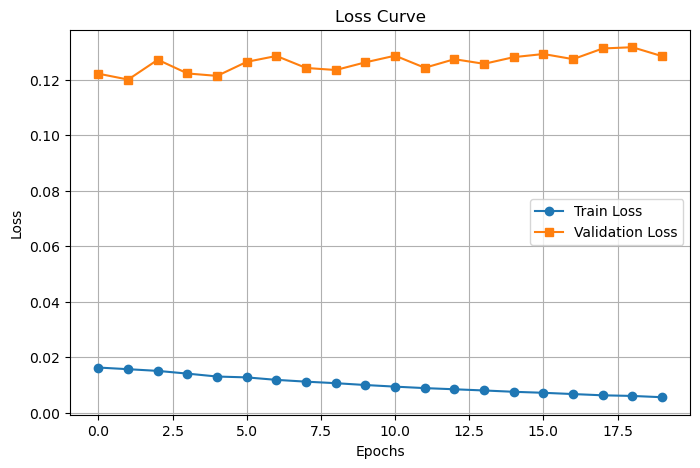

In [48]:
# Plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()
plt.show()



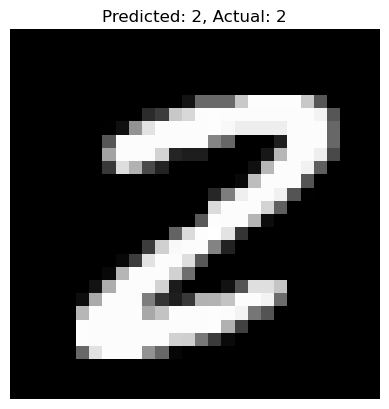

Predicted Label: 2, Actual Label: 2
Correct


In [258]:
# Test on a random image
idx = np.random.randint(len(x_test))
random_img = x_test[idx].reshape(1, -1)

z1_test = np.dot(random_img, w1) + b1
a1_test = sigmoid(z1_test)
z2_test = np.dot(a1_test, w2) + b2
a2_test = relu(z2_test)
z3_test = np.dot(a2_test, w3) + b3
a3_test = softmax(z3_test)

predicted_label = np.argmax(a3_test)
actual_label = np.argmax(y_test[idx])

plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
plt.axis("off")
plt.show()
print(f"Predicted Label: {predicted_label}, Actual Label: {actual_label}")
if predicted_label == actual_label:
    print("Correct")
else:
    print("Incorrect")